In [782]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from IPython.core.display import HTML
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from ipywidgets import interact
import statistics as st
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, PolynomialFeatures, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import accuracy_score
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier 

In [709]:
faults = pd.read_csv('../data/J1939Faults.csv', 
                    usecols=['RecordID',
                             'EventTimeStamp',
                            'eventDescription',
                            'ecuSerialNumber',
                            'ecuSource',
                            'spn',
                            'fmi',
                            'active',
                            'activeTransitionCount',
                            'EquipmentID',
                            'Latitude',
                            'Longitude',
                            'LocationTimeStamp'
                            ])
faults['EventTimeStamp'] = pd.to_datetime(faults['EventTimeStamp'])
faults['LocationTimeStamp'] = pd.to_datetime(faults['LocationTimeStamp'])
faults['EventMonth'] = pd.DatetimeIndex(faults['EventTimeStamp']).month
faults['EquipmentID'] = faults['EquipmentID'].astype(str)
diag = pd.read_csv('../data/VehicleDiagnosticOnboardData.csv')

vehicle = pd.read_excel('../data/Vehicle_Make.xlsx')
fault_code = pd.read_excel('../data/Service Fault Codes_1_0_0_167.xlsx')

/Users/chengxianzhang/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3186: DtypeWarning: Columns (15) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/Users/chengxianzhang/anaconda3/lib/python3.7/site-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Data Validation extension is not supported and will be removed
  warn(msg)


In [710]:
pd.set_option('display.max_rows', 20)

In [711]:
faults[faults['spn']==5246].nunique()

RecordID                 1195
EventTimeStamp           1183
eventDescription            0
ecuSerialNumber           182
ecuSource                   2
spn                         1
fmi                         5
active                      2
activeTransitionCount      54
EquipmentID               215
Latitude                  852
Longitude                 855
LocationTimeStamp        1150
EventMonth                 12
dtype: int64

In [712]:
faults.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1187335 entries, 0 to 1187334
Data columns (total 14 columns):
 #   Column                 Non-Null Count    Dtype         
---  ------                 --------------    -----         
 0   RecordID               1187335 non-null  int64         
 1   EventTimeStamp         1187335 non-null  datetime64[ns]
 2   eventDescription       1126490 non-null  object        
 3   ecuSerialNumber        844318 non-null   object        
 4   ecuSource              1187335 non-null  int64         
 5   spn                    1187335 non-null  int64         
 6   fmi                    1187335 non-null  int64         
 7   active                 1187335 non-null  bool          
 8   activeTransitionCount  1187335 non-null  int64         
 9   EquipmentID            1187335 non-null  object        
 10  Latitude               1187335 non-null  float64       
 11  Longitude              1187335 non-null  float64       
 12  LocationTimeStamp      11873

In [713]:
faults = faults[faults['EventTimeStamp']>= '2015-01-01']

In [714]:
# Full derate with spn 5246 and Active == True

derate = faults[(faults['spn']==5246) & (faults['active']==True) ]

In [715]:
derate.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 602 entries, 45 to 1184330
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   RecordID               602 non-null    int64         
 1   EventTimeStamp         602 non-null    datetime64[ns]
 2   eventDescription       0 non-null      object        
 3   ecuSerialNumber        493 non-null    object        
 4   ecuSource              602 non-null    int64         
 5   spn                    602 non-null    int64         
 6   fmi                    602 non-null    int64         
 7   active                 602 non-null    bool          
 8   activeTransitionCount  602 non-null    int64         
 9   EquipmentID            602 non-null    object        
 10  Latitude               602 non-null    float64       
 11  Longitude              602 non-null    float64       
 12  LocationTimeStamp      602 non-null    datetime64[ns]
 13  

In [716]:
derate.sort_values(['EquipmentID','EventTimeStamp']).head(20)

,RecordID,EventTimeStamp,eventDescription,ecuSerialNumber,ecuSource,spn,fmi,active,activeTransitionCount,EquipmentID,Latitude,Longitude,LocationTimeStamp,EventMonth
996835,1032993,2018-07-06 09:42:48,NaN,79903644,0,5246,0,True,1,105349576,36.068564,-79.272268,2018-07-06 09:43:24,7
156410,158796,2015-08-10 10:26:40,NaN,79481949,0,5246,0,True,1,105360462,36.066759,-86.434120,2015-08-10 10:27:17,8
185581,187967,2015-08-31 13:50:42,NaN,79481949,0,5246,0,True,1,105411041,36.066666,-86.434120,2015-08-31 13:51:19,8
972882,1004301,2018-04-27 06:07:55,NaN,79875551,0,5246,0,True,1,105427203,36.466990,-86.687268,2018-04-27 06:08:31,4
5713,5714,2015-02-25 13:53:08,NaN,unknown,0,5246,0,True,1,1329,39.399583,-82.974768,2015-02-25 13:56:31,2
83425,85811,2015-06-12 15:35:22,NaN,unknown,0,5246,0,True,1,1339,37.035324,-86.336018,2015-06-12 15:35:58,6
82772,85158,2015-06-12 06:13:27,NaN,unknown,0,5246,0,True,1,1366,35.146018,-86.578888,2015-06-12 07:17:28,6
83703,86089,2015-06-13 03:33:30,NaN,unknown,0,5246,0,True,1,1366,33.208888,-84.055972,2015-06-13 03:34:06,6
107460,109846,2015-07-03 19:10:35,NaN,79452482,0,5246,0,True,1,1366,35.724212,-86.321296,2015-07-03 19:12:41,7
212164,214550,2015-09-23 10:28:29,NaN,79452482,0,5246,0,True,1,1366,35.151990,-84.954074,2015-09-23 10:29:05,9


In [717]:
derate[derate['EquipmentID']=='1630']

,RecordID,EventTimeStamp,eventDescription,ecuSerialNumber,ecuSource,spn,fmi,active,activeTransitionCount,EquipmentID,Latitude,Longitude,LocationTimeStamp,EventMonth
2089,2090,2015-02-23 05:05:44,NaN,79642446,0,5246,0,True,1,1630,40.733009,-74.087777,2015-02-23 05:08:23,2
861452,884718,2017-10-04 05:56:17,NaN,79642446,0,5246,0,True,1,1630,37.839675,-80.753611,2017-10-04 05:56:52,10


In [718]:
faults[faults['EquipmentID']=='1630']

,RecordID,EventTimeStamp,eventDescription,ecuSerialNumber,ecuSource,spn,fmi,active,activeTransitionCount,EquipmentID,Latitude,Longitude,LocationTimeStamp,EventMonth
66,67,2015-02-21 12:25:26,Low (Severity Medium) Engine Coolant Level,79642446,0,111,18,True,3,1630,35.587592,-86.443796,2015-02-21 12:27:08,2
67,68,2015-02-21 12:25:37,Low (Severity High) Engine Coolant Level,79642446,0,111,1,True,3,1630,35.587592,-86.443796,2015-02-21 12:27:08,2
68,69,2015-02-21 12:25:44,Abnormal Update Rate Tire Location,unknown,49,929,9,True,126,1630,35.587592,-86.443796,2015-02-21 12:27:09,2
80,81,2015-02-21 12:33:52,Abnormal Update Rate Tire Location,unknown,49,929,9,False,126,1630,35.586944,-86.443657,2015-02-21 12:33:48,2
82,83,2015-02-21 12:35:04,Low (Severity Medium) Engine Coolant Level,79642446,0,111,18,False,3,1630,35.586712,-86.443611,2015-02-21 12:35:00,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
951045,980571,2018-03-09 09:42:56,Abnormal Update Rate Tire Location,unknown,49,929,9,False,126,1630,36.066759,-86.434027,2018-03-09 09:42:52,3
951046,980572,2018-03-09 09:43:15,Abnormal Update Rate Tire Location,unknown,49,929,9,True,126,1630,36.066759,-86.434166,2018-03-09 09:43:52,3
951048,980574,2018-03-09 09:51:47,Abnormal Update Rate Tire Location,unknown,49,929,9,False,126,1630,36.066712,-86.434166,2018-03-09 09:51:43,3
955026,984552,2018-03-09 09:52:14,Abnormal Update Rate Tire Location,unknown,49,929,9,True,126,1630,36.066342,-86.434722,2018-03-09 17:54:07,3


In [719]:
event_month = pd.DataFrame(derate['EventMonth'].value_counts().to_frame().sort_index().reset_index())

In [720]:
event_month.rename(columns = {'index':'month', 'EventMonth':'full_derate_count'}, inplace=True)

In [721]:
event_month

,month,full_derate_count
0,1,59
1,2,86
2,3,38
3,4,53
4,5,56
5,6,42
6,7,51
7,8,46
8,9,28
9,10,31


In [722]:
event_month.columns

Index(['month', 'full_derate_count'], dtype='object')

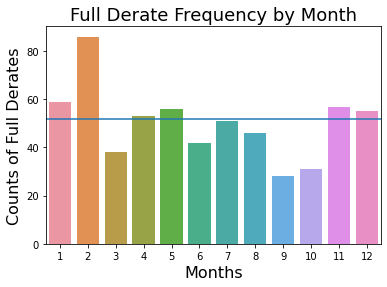

In [723]:
sns.barplot(data = event_month, x= 'month', y = 'full_derate_count').axhline(np.median(event_month['full_derate_count']))
plt.title('Full Derate Frequency by Month', fontsize = 18)
plt.xlabel('Months', fontsize = 16)
plt.ylabel('Counts of Full Derates', fontsize = 16);
plt.savefig("derate_month.png", dpi = 300)


In [724]:
# diag_pivoted = pd.pivot_table(diag, columns= ['Name'], values = 'Value', index = 'FaultId', aggfunc= 'first').reset_index()

# faults_diag = faults.merge(diag_pivoted, left_on = 'RecordID', right_on = 'FaultId')

# derate = faults_diag[faults_diag['spn']==5246]

In [725]:
from folium import plugins
from folium.plugins import HeatMap


map_hooray = folium.Map(location=[35.860119, -86.660156],
                    zoom_start = 5) 

heat_df = derate[['Latitude','Longitude']]

# List comprehension to make out list of lists
heat_data = [[row['Latitude'],row['Longitude']] for index, row in heat_df.iterrows()]

# Plot it on the map
HeatMap(heat_data).add_to(map_hooray)

# render HTML
map_hooray.save('derate_location.html')

# Display the map
map_hooray

In [726]:
derated_truck_ID = derate['EquipmentID'].unique()

In [727]:
derated_truck_ID

array(['1395', '1630', '1487', '1329', '1419', '1486', '1509', '1492',
       '1473', '1383', '1396', '1602', '1431', '1795', '1595', '1366',
       '1339', '1391', '1399', '1417', '1591', '1490', '1547', '1444',
       '1457', '105360462', '1437', '1453', '1584', '1692', '105411041',
       '1590', '1398', '1418', '1472', '1560', '1572', '1375', '1742',
       '1566', '1778', '1524', '305', '1659', '1403', '1535', '1567',
       '1373', '1665', '1551', '1440', '1571', '1443', '1378', '1452',
       '1488', '1384', '304', '1582', '1508', '1599', '1501', '1407',
       '1603', '1604', '1477', '1389', '1519', '1757', '1458', '1401',
       '1467', '1579', '1534', '1575', '1539', '1601', '1657', '1592',
       '1563', '1557', '1605', '1581', '301', '1811', '1573', '1594',
       '1668', '1643', '1561', '1549', '1940', '1839', '1552', '1637',
       '1554', '1529', '1686', '1598', '1828', '1745', '1525', '1848',
       '1537', '1521', '1661', '1831', '1528', '1654', '1917', '1543',
       

In [728]:
derated_truck = faults[faults['EquipmentID'].isin(derated_truck_ID)]

In [729]:
# most common spn for derated trucks
derated_truck['spn'].value_counts()

# 111 Low (Severity Medium) Engine Coolant Level
# 929 Abnormal Update Rate Tire Location
# 96 High Voltage (Fuel Level)
# 829 High Voltage (Left Fuel Level Sensor)
# 639 Incorrect Data J1939 Network #1 Primary Vehicl...


111      180711
929       38507
96        32518
829       30069
639        8529
          ...  
2029          2
47284         2
6713          2
3663          1
3241          1
Name: spn, Length: 339, dtype: int64

In [730]:
derated_truck[derated_truck['spn']==639]

,RecordID,EventTimeStamp,eventDescription,ecuSerialNumber,ecuSource,spn,fmi,active,activeTransitionCount,EquipmentID,Latitude,Longitude,LocationTimeStamp,EventMonth
2520,2521,2015-02-23 10:47:07,Incorrect Data J1939 Network #1 Primary Vehicl...,unknown,11,639,2,True,127,1768,36.067037,-86.434351,2015-02-23 10:01:55,2
2527,2528,2015-02-23 10:54:20,Incorrect Data J1939 Network #1 Primary Vehicl...,unknown,11,639,2,False,127,1768,36.067037,-86.434768,2015-02-23 10:52:22,2
5778,5779,2015-02-25 14:23:20,Incorrect Data J1939 Network #1 Primary Vehicl...,unknown,11,639,2,True,127,1621,39.945277,-82.536620,2015-02-25 14:23:56,2
5807,5808,2015-02-25 14:45:09,Incorrect Data J1939 Network #1 Primary Vehicl...,unknown,11,639,2,False,127,1621,39.945370,-82.536064,2015-02-25 14:45:05,2
6618,6619,2015-02-27 08:35:41,Incorrect Data J1939 Network #1 Primary Vehicl...,unknown,11,639,2,True,127,1605,41.832268,-87.748240,2015-02-27 08:36:17,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1185363,1246487,2020-02-27 16:50:29,NaN,K1240376,3,639,12,False,22,2089,39.161851,-76.781620,2020-02-27 16:50:30,2
1186388,1247512,2020-03-03 15:34:13,NaN,K1240376,3,639,12,True,26,2089,30.372083,-81.834629,2020-03-03 15:42:17,3
1186389,1247513,2020-03-03 15:42:13,NaN,K1240376,3,639,12,False,26,2089,30.372083,-81.834629,2020-03-03 15:42:18,3
1187241,1248365,2020-03-06 09:23:24,Incorrect Data J1939 Network #1 Primary Vehicl...,unknown,11,639,2,True,127,2089,29.265370,-82.189629,2020-03-06 09:24:01,3


In [731]:
derated_truck[derated_truck['EquipmentID']=='1395']

,RecordID,EventTimeStamp,eventDescription,ecuSerialNumber,ecuSource,spn,fmi,active,activeTransitionCount,EquipmentID,Latitude,Longitude,LocationTimeStamp,EventMonth
45,46,2015-02-21 12:10:51,NaN,79464664,0,5246,0,True,1,1395,36.065972,-86.433425,2015-02-21 12:11:27,2
1916,1917,2015-02-22 19:44:55,Low Voltage (Aftertreatment 1 Outlet NOx),79464664,0,3226,4,True,1,1395,36.066203,-86.434814,2015-02-22 19:46:27,2
1917,1918,2015-02-22 19:44:55,Condition Exists Engine Protection Torque Derate,79464664,0,1569,31,True,1,1395,36.066203,-86.434814,2015-02-22 19:46:27,2
1918,1919,2015-02-22 19:44:55,NaN,79464664,0,5246,0,True,1,1395,36.066203,-86.434814,2015-02-22 19:46:27,2
1919,1920,2015-02-22 19:44:55,Abnormal Rate of Change Aftertreatment 1 Outle...,79464664,0,3226,10,True,1,1395,36.066203,-86.434814,2015-02-22 19:46:27,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
439557,447824,2016-04-14 16:43:08,NaN,79464664,0,4364,18,False,1,1395,39.943981,-82.535416,2016-04-14 16:43:04,4
439669,447936,2016-04-14 19:53:32,NaN,79464664,0,4364,18,True,1,1395,38.465138,-85.285601,2016-04-14 19:54:08,4
440600,448867,2016-04-15 14:44:36,Incorrect Data Brake Light Switch 1,Q491011011,11,1045,2,True,127,1395,36.192546,-86.411296,2016-04-15 14:45:13,4
440813,449080,2016-04-15 18:57:09,Incorrect Data Brake Light Switch 1,Q491011011,11,1045,2,False,127,1395,36.179953,-86.297870,2016-04-15 18:57:05,4


In [732]:
derated_truck[derated_truck['EquipmentID']=='1630']

,RecordID,EventTimeStamp,eventDescription,ecuSerialNumber,ecuSource,spn,fmi,active,activeTransitionCount,EquipmentID,Latitude,Longitude,LocationTimeStamp,EventMonth
66,67,2015-02-21 12:25:26,Low (Severity Medium) Engine Coolant Level,79642446,0,111,18,True,3,1630,35.587592,-86.443796,2015-02-21 12:27:08,2
67,68,2015-02-21 12:25:37,Low (Severity High) Engine Coolant Level,79642446,0,111,1,True,3,1630,35.587592,-86.443796,2015-02-21 12:27:08,2
68,69,2015-02-21 12:25:44,Abnormal Update Rate Tire Location,unknown,49,929,9,True,126,1630,35.587592,-86.443796,2015-02-21 12:27:09,2
80,81,2015-02-21 12:33:52,Abnormal Update Rate Tire Location,unknown,49,929,9,False,126,1630,35.586944,-86.443657,2015-02-21 12:33:48,2
82,83,2015-02-21 12:35:04,Low (Severity Medium) Engine Coolant Level,79642446,0,111,18,False,3,1630,35.586712,-86.443611,2015-02-21 12:35:00,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
951045,980571,2018-03-09 09:42:56,Abnormal Update Rate Tire Location,unknown,49,929,9,False,126,1630,36.066759,-86.434027,2018-03-09 09:42:52,3
951046,980572,2018-03-09 09:43:15,Abnormal Update Rate Tire Location,unknown,49,929,9,True,126,1630,36.066759,-86.434166,2018-03-09 09:43:52,3
951048,980574,2018-03-09 09:51:47,Abnormal Update Rate Tire Location,unknown,49,929,9,False,126,1630,36.066712,-86.434166,2018-03-09 09:51:43,3
955026,984552,2018-03-09 09:52:14,Abnormal Update Rate Tire Location,unknown,49,929,9,True,126,1630,36.066342,-86.434722,2018-03-09 17:54:07,3


In [733]:
derated_truck[derated_truck['EquipmentID']=='1487']

,RecordID,EventTimeStamp,eventDescription,ecuSerialNumber,ecuSource,spn,fmi,active,activeTransitionCount,EquipmentID,Latitude,Longitude,LocationTimeStamp,EventMonth
2216,2217,2015-02-23 07:15:48,NaN,unknown,0,4334,3,True,1,1487,25.878518,-80.357222,2015-02-23 07:16:24,2
2217,2218,2015-02-23 07:16:03,Condition Exists Engine Protection Torque Derate,unknown,0,1569,31,True,1,1487,25.878518,-80.357222,2015-02-23 07:16:39,2
2293,2294,2015-02-23 07:56:08,Condition Exists Catalyst Dosing Unit Input Lines,unknown,0,3362,31,True,1,1487,25.861342,-80.371851,2015-02-23 07:56:44,2
2395,2396,2015-02-23 09:16:02,Condition Exists Engine Protection Torque Derate,unknown,0,1569,31,False,1,1487,25.860277,-80.371712,2015-02-23 09:15:58,2
2440,2441,2015-02-23 09:51:41,Condition Exists Engine Protection Torque Derate,unknown,0,1569,31,True,1,1487,25.861898,-80.373101,2015-02-23 09:52:16,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
540430,553278,2016-08-08 23:47:15,Low (Severity Medium) Engine Coolant Level,79487660,0,111,18,True,1,1487,36.073101,-86.429444,2016-08-08 23:47:52,8
544749,557597,2016-08-14 02:32:32,NaN,79487660,0,5491,5,True,1,1487,36.066898,-86.434120,2016-08-14 02:33:08,8
549997,563615,2016-08-19 14:20:47,Low (Severity Medium) Engine Coolant Level,79929876,0,111,18,False,1,1487,35.588148,-86.443842,2016-08-19 14:20:42,8
549998,563616,2016-08-19 14:20:47,NaN,unknown,49,524033,31,False,9,1487,35.588148,-86.443842,2016-08-19 14:20:42,8


In [734]:
derate.groupby(['EquipmentID']).size()

EquipmentID
105349576     1
105360462     1
105411041     1
105427203     1
1329          1
             ..
301           3
302           3
304           1
305          14
306           1
Length: 211, dtype: int64

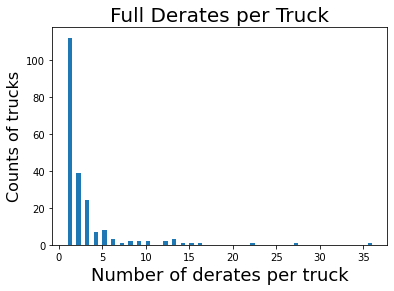

In [735]:
# Frequency of derates
plt.hist(derate.groupby(['EquipmentID']).size().to_list(), bins = 70)
plt.title('Full Derates per Truck', fontsize=20)
plt.xlabel('Number of derates per truck', fontsize=18)
plt.ylabel('Counts of trucks', fontsize=16)
plt.savefig('derate_freq.png', dpi = 300);

In [736]:
derate.groupby(['EquipmentID'])['spn'].count().sort_values(ascending = False)

EquipmentID
1524    36
1535    27
1525    22
1539    16
1749    15
        ..
1594     1
1592     1
1590     1
1585     1
306      1
Name: spn, Length: 211, dtype: int64

In [737]:
derate.groupby('EquipmentID').size().sort_values()

EquipmentID
105349576     1
1731          1
1732          1
1742          1
1743          1
             ..
1749         15
1539         16
1525         22
1535         27
1524         36
Length: 211, dtype: int64

In [738]:
# Percentile of Frequency of Full Derates
for x in range(5, 101, 5):
    derate_quantile = derate.groupby(['EquipmentID']).size().quantile(x/100)
    print(f'{x} percentile', derate_quantile)

5 percentile 1.0
10 percentile 1.0
15 percentile 1.0
20 percentile 1.0
25 percentile 1.0
30 percentile 1.0
35 percentile 1.0
40 percentile 1.0
45 percentile 1.0
50 percentile 1.0
55 percentile 2.0
60 percentile 2.0
65 percentile 2.0
70 percentile 2.0
75 percentile 3.0
80 percentile 3.0
85 percentile 4.0
90 percentile 5.0
95 percentile 11.0
100 percentile 36.0


In [739]:
derate['diff'] = derate.sort_values(['EquipmentID','EventTimeStamp']).groupby('EquipmentID')['EventTimeStamp'].diff()
derate["diff"] = derate["diff"].apply(lambda x: x/np.timedelta64(1, 'D')).fillna(0).astype('float')

/Users/chengxianzhang/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/chengxianzhang/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


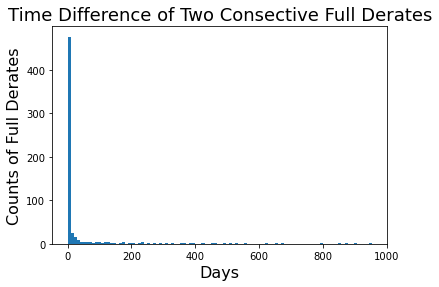

In [740]:
# time difference of full derate
plt.hist(derate['diff'], bins = 100)
plt.title('Time Difference of Two Consective Full Derates', fontsize = 18)
plt.xlabel('Days', fontsize = 16)
plt.ylabel('Counts of Full Derates', fontsize = 16)
plt.savefig('time_diff_derate.png', dpi = 300);

In [741]:
# Percentile of Time Difference Between Two Consecutive Full Derates
for x in range(5, 101, 5):
    derate_quantile = derate['diff'].quantile(x/100)
    print(f'{x} percentile', derate_quantile)

5 percentile 0.0
10 percentile 0.0
15 percentile 0.0
20 percentile 0.0
25 percentile 0.0
30 percentile 0.0
35 percentile 0.0
40 percentile 0.026585648148148153
45 percentile 0.04477372685185184
50 percentile 0.10884837962962962
55 percentile 0.22067881944444448
60 percentile 0.4812499999999997
65 percentile 0.8575972222222226
70 percentile 1.7417256944444437
75 percentile 4.649140625
80 percentile 10.79882638888889
85 percentile 23.443414930555548
90 percentile 91.31337847222198
95 percentile 230.58610011574072
100 percentile 954.0351041666667


In [742]:
truck_first_derate_time = derate.groupby('EquipmentID').agg({'EventTimeStamp':'min'}).reset_index().rename({'EventTimeStamp':'first_derate_time'}, axis = 1)

In [743]:
derated_truck = (derated_truck.
 merge(truck_first_derate_time, how = 'left', on = 'EquipmentID' ).
 sort_values(['EquipmentID', 'EventTimeStamp'], ascending = [False, True])
)

In [744]:
derated_truck.shape

(390003, 15)

In [745]:
events_before_first_derate = derated_truck[derated_truck['EventTimeStamp'] <= derated_truck['first_derate_time']]

In [746]:
events_before_first_derate['spn_count'] = 1
events_before_derate_pivoted = events_before_first_derate.pivot_table(index = ['EquipmentID', 'EventTimeStamp'], columns = 'spn', values = 'spn_count').fillna(0).reset_index().rename_axis(None, axis=1)

/Users/chengxianzhang/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [747]:
events_before_derate_pivoted.sum()

EquipmentID    1053495761053495761053495761053495761053495761...
0                                                           94.0
16                                                          10.0
27                                                          29.0
37                                                          44.0
                                     ...                        
520273                                                      14.0
520953                                                       3.0
523530                                                      10.0
523531                                                      30.0
524287                                                      17.0
Length: 287, dtype: object

In [748]:
derate_events_rolling = events_before_derate_pivoted.set_index('EventTimeStamp').groupby('EquipmentID').rolling(window = '7D').sum().drop(columns = 'EquipmentID').reset_index()

In [749]:
derate_events_rolling.sum()

EquipmentID    1053495761053495761053495761053495761053495761...
0                                                         4485.0
16                                                         136.0
27                                                         464.0
37                                                         134.0
                                     ...                        
520273                                                     133.0
520953                                                       6.0
523530                                                      52.0
523531                                                     158.0
524287                                                     507.0
Length: 287, dtype: object

In [750]:
derate_events_rolling[derate_events_rolling[5246]>0]

,EquipmentID,EventTimeStamp,0,16,27,37,38,51,70,74,...,51923,65302,65303,65535,520203,520273,520953,523530,523531,524287
9,105349576,2018-07-06 09:42:48,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10,105360462,2015-08-10 10:26:40,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11,105411041,2015-08-31 13:50:42,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14,105427203,2018-04-27 06:07:55,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15,1329,2015-02-25 13:53:08,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
196329,301,2016-07-11 10:53:16,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
198504,302,2020-01-06 10:13:57,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
199407,304,2016-02-15 10:59:28,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
202316,305,2015-12-14 18:25:46,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [751]:
derated_truck[(derated_truck['EquipmentID']=="1605")&(derated_truck['spn']==5246)]

,RecordID,EventTimeStamp,eventDescription,ecuSerialNumber,ecuSource,spn,fmi,active,activeTransitionCount,EquipmentID,Latitude,Longitude,LocationTimeStamp,EventMonth,first_derate_time
179912,513429,2016-06-27 13:49:41,NaN,79634897,0,5246,0,True,1,1605,39.589629,-76.065740,2016-06-27 13:50:16,6,2016-06-27 13:49:41
180324,514406,2016-06-28 14:16:03,NaN,79634897,0,5246,0,False,1,1605,39.609583,-75.902916,2016-06-28 14:10:44,6,2016-06-27 13:49:41


In [752]:
before_first_derate_1605 = derate_events_rolling[(derate_events_rolling['EquipmentID']=="1605")].reset_index()

In [753]:
before_first_derate_1605['Target'] = np.where((before_first_derate_1605[5246]==1), 1, 0)

In [754]:
before_first_derate_1605

,index,EquipmentID,EventTimeStamp,0,16,27,37,38,51,70,...,65302,65303,65535,520203,520273,520953,523530,523531,524287,Target
0,83315,1605,2015-02-21 11:52:46,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,83316,1605,2015-02-21 11:53:52,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,83317,1605,2015-02-21 13:08:50,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,83318,1605,2015-02-21 13:09:56,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,83319,1605,2015-02-21 13:21:35,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7730,91045,1605,2016-06-27 12:40:22,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
7731,91046,1605,2016-06-27 12:40:30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
7732,91047,1605,2016-06-27 13:33:20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
7733,91048,1605,2016-06-27 13:33:44,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [755]:
before_first_derate_1605.iloc[-2, -1] = 1

In [756]:
before_first_derate_1605.iloc[:-1]

,index,EquipmentID,EventTimeStamp,0,16,27,37,38,51,70,...,65302,65303,65535,520203,520273,520953,523530,523531,524287,Target
0,83315,1605,2015-02-21 11:52:46,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,83316,1605,2015-02-21 11:53:52,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,83317,1605,2015-02-21 13:08:50,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,83318,1605,2015-02-21 13:09:56,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,83319,1605,2015-02-21 13:21:35,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7729,91044,1605,2016-06-27 12:29:21,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
7730,91045,1605,2016-06-27 12:40:22,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
7731,91046,1605,2016-06-27 12:40:30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
7732,91047,1605,2016-06-27 13:33:20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [757]:
df = derate_events_rolling.value_counts('EquipmentID').to_frame().reset_index()
new_derate_truck_ID = df[df[0]>1]['EquipmentID'].to_list()

In [758]:
type(new_derate_truck_ID)

list

In [759]:
df[df[0]>1].sort_values(0)

,EquipmentID,0
204,1539,2
203,105427203,3
202,1486,4
199,2009,5
201,2209,5
...,...,...
4,1803,5638
3,1815,6336
2,1808,6519
1,1605,7735


In [760]:
df = df[df[0]>1]

In [761]:
faults[faults['EquipmentID']=='1452'].sort_values('EventTimeStamp')

,RecordID,EventTimeStamp,eventDescription,ecuSerialNumber,ecuSource,spn,fmi,active,activeTransitionCount,EquipmentID,Latitude,Longitude,LocationTimeStamp,EventMonth
1604,1605,2015-02-22 11:36:37,Condition Exists Cruise Control Enable Switch,unknown,49,596,31,False,56,1452,35.821203,-79.823379,2015-02-22 11:38:04,2
1830,1831,2015-02-22 16:36:29,Condition Exists Cruise Control Enable Switch,unknown,49,596,31,True,57,1452,35.886666,-79.821666,2015-02-22 16:37:05,2
1852,1853,2015-02-22 17:22:05,Condition Exists Cruise Control Enable Switch,unknown,49,596,31,False,57,1452,36.065833,-79.309120,2015-02-22 17:22:00,2
1860,1861,2015-02-22 17:41:02,Condition Exists Cruise Control Enable Switch,unknown,49,596,31,True,58,1452,36.077314,-79.208194,2015-02-22 17:41:38,2
1897,1898,2015-02-22 18:55:11,NaN,unknown,49,50353,0,True,2,1452,35.913518,-78.168333,2015-02-22 18:55:47,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
486462,495579,2016-06-07 13:51:03,Low (Severity Low) Engine Coolant Level,79475366,0,111,17,True,1,1452,36.066759,-86.434074,2016-06-07 13:53:10,6
486465,495582,2016-06-07 13:54:38,Low (Severity Low) Engine Coolant Level,79475366,0,111,17,False,1,1452,36.067129,-86.434074,2016-06-07 13:54:33,6
488030,497147,2016-06-09 08:31:09,Low (Severity Low) Engine Coolant Level,79475366,0,111,17,True,1,1452,35.588055,-86.444074,2016-06-09 08:33:11,6
497942,508891,2016-06-22 05:49:36,Incorrect Data Axle Load Sensor,5N45151865,11,1059,2,True,11,1452,35.588194,-86.443842,2016-06-22 05:50:12,6


In [762]:
events_before_first_derate[events_before_first_derate['EquipmentID']=='1452']

,RecordID,EventTimeStamp,eventDescription,ecuSerialNumber,ecuSource,spn,fmi,active,activeTransitionCount,EquipmentID,Latitude,Longitude,LocationTimeStamp,EventMonth,first_derate_time,spn_count
573,1605,2015-02-22 11:36:37,Condition Exists Cruise Control Enable Switch,unknown,49,596,31,False,56,1452,35.821203,-79.823379,2015-02-22 11:38:04,2,2016-02-10 06:48:36,1
637,1831,2015-02-22 16:36:29,Condition Exists Cruise Control Enable Switch,unknown,49,596,31,True,57,1452,35.886666,-79.821666,2015-02-22 16:37:05,2,2016-02-10 06:48:36,1
642,1853,2015-02-22 17:22:05,Condition Exists Cruise Control Enable Switch,unknown,49,596,31,False,57,1452,36.065833,-79.309120,2015-02-22 17:22:00,2,2016-02-10 06:48:36,1
645,1861,2015-02-22 17:41:02,Condition Exists Cruise Control Enable Switch,unknown,49,596,31,True,58,1452,36.077314,-79.208194,2015-02-22 17:41:38,2,2016-02-10 06:48:36,1
661,1898,2015-02-22 18:55:11,NaN,unknown,49,50353,0,True,2,1452,35.913518,-78.168333,2015-02-22 18:55:47,2,2016-02-10 06:48:36,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
133930,378059,2016-02-09 15:27:16,NaN,unknown,49,50353,0,False,2,1452,39.616250,-84.231666,2016-02-08 14:17:33,2,2016-02-10 06:48:36,1
133932,378062,2016-02-10 06:36:02,Incorrect Data Keyswitch Battery Potential,unknown,49,158,2,True,1,1452,39.616250,-84.231666,2016-02-08 14:17:33,2,2016-02-10 06:48:36,1
133931,378061,2016-02-10 06:36:03,Abnormal Update Rate Aftertreatment 1 Intake NOx,79475366,0,3216,9,True,1,1452,39.616250,-84.231666,2016-02-08 14:17:33,2,2016-02-10 06:48:36,1
133935,378065,2016-02-10 06:48:36,Abnormal Update Rate Aftertreatment 1 Intake NOx,79475366,0,3216,9,True,1,1452,39.616250,-84.231666,2016-02-08 14:17:33,2,2016-02-10 06:48:36,1


(array([61., 23., 11.,  9., 12.,  6.,  9.,  5.,  7.,  8.,  6.,  5.,  2.,
         3.,  2.,  1.,  4.,  2.,  0.,  5.,  2.,  2.,  1.,  0.,  2.,  1.,
         3.,  1.,  1.,  1.,  3.,  1.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,
         2.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,
         2.,  0.,  0.,  0.,  2.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,
         1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([1.00000e+00, 1.01220e+02, 2.01440e+02, 3.01660e+02, 4.01880e+02,
        5.02100e+02, 6.02320e+02, 7.02540e+02, 8.02760e+02, 9.02980e+02,
        1.00320e+03, 1.10342e+03, 1.20364e+03, 1.30386e+03, 1.40408e+03,
        1.50430e+03, 1.60452e+03, 1.70474e+03, 1.80496e+03, 1.90518e+03,
        2.00540e+03, 2.10562e+03, 2.20584e+03, 2.30606e+03, 2.40628e+03,
        2.50650e+03, 2.60672e+03, 2.70694e+03, 2.80716e+03, 2.90738e+

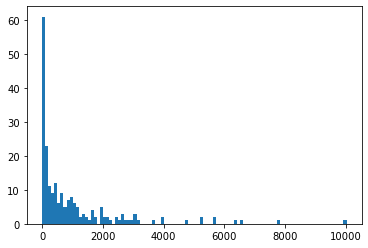

In [763]:
plt.hist(derate_events_rolling.value_counts('EquipmentID'), bins = 100)

In [764]:
new_derate_truck_ID

['1623',
 '1605',
 '1808',
 '1815',
 '1803',
 '1600',
 '1814',
 '1559',
 '1818',
 '1749',
 '1692',
 '1592',
 '1564',
 '1556',
 '1601',
 '1819',
 '305',
 '1811',
 '1554',
 '1585',
 '1739',
 '1573',
 '1594',
 '1579',
 '1598',
 '1552',
 '302',
 '1812',
 '1586',
 '1860',
 '1437',
 '1557',
 '1590',
 '1748',
 '1603',
 '1563',
 '1561',
 '1669',
 '1764',
 '1864',
 '1378',
 '1691',
 '1621',
 '1731',
 '1575',
 '1547',
 '1878',
 '1560',
 '1440',
 '1373',
 '1581',
 '1401',
 '1403',
 '1970',
 '1584',
 '1698',
 '1654',
 '2082',
 '1683',
 '1661',
 '1375',
 '1939',
 '1537',
 '1950',
 '1384',
 '1582',
 '1604',
 '304',
 '1758',
 '1874',
 '1921',
 '1567',
 '1389',
 '1857',
 '1853',
 '1663',
 '1768',
 '1918',
 '1976',
 '1591',
 '1985',
 '1452',
 '1854',
 '1879',
 '1743',
 '1732',
 '2005',
 '1946',
 '1922',
 '1566',
 '1745',
 '1794',
 '1467',
 '1689',
 '1947',
 '1488',
 '1711',
 '1718',
 '1458',
 '1417',
 '1686',
 '1896',
 '1399',
 '1602',
 '1443',
 '1704',
 '306',
 '1746',
 '1885',
 '1637',
 '1858',
 '159

In [765]:
# before_derate_rolling_target = []
# for x in new_derate_truck_ID:
#     df = derate_events_rolling[(derate_events_rolling['EquipmentID']==x)].reset_index()
#     df['Target'] = np.where((df[5246]==1), 1, 0)
#     df.iloc[-2, -1] = 1
#     before_derate_rolling_target.append(df.iloc[:-1])
#new_derate_truck_ID = ['1539', '105427203']    
    
before_derate_rolling_target = []
for x in new_derate_truck_ID:
    print(x)
    df = derate_events_rolling[(derate_events_rolling['EquipmentID']==x)].reset_index()
    df['Target'] = np.where((df[5246]==1), 1, 0)
    df.iloc[-2, -1] = 1
    df_temp = df.iloc[:-1]
    before_derate_rolling_target.append(df_temp)  
    

1623
1605
1808
1815
1803
1600
1814
1559
1818
1749
1692
1592
1564
1556
1601
1819
305
1811
1554
1585
1739
1573
1594
1579
1598
1552
302
1812
1586
1860
1437
1557
1590
1748
1603
1563
1561
1669
1764
1864
1378
1691
1621
1731
1575
1547
1878
1560
1440
1373
1581
1401
1403
1970
1584
1698
1654
2082
1683
1661
1375
1939
1537
1950
1384
1582
1604
304
1758
1874
1921
1567
1389
1857
1853
1663
1768
1918
1976
1591
1985
1452
1854
1879
1743
1732
2005
1946
1922
1566
1745
1794
1467
1689
1947
1488
1711
1718
1458
1417
1686
1896
1399
1602
1443
1704
306
1746
1885
1637
1858
1595
1907
1659
1398
1391
1964
1643
1525
1665
301
1772
1847
1951
1508
1657
1800
1407
1780
1528
1958
1571
1757
1668
1942
1797
1932
1551
1872
1842
1519
1457
1961
2004
1521
1778
2089
2030
1492
1978
1529
1991
1366
1453
1919
2109
1928
1444
1383
1856
1839
1877
1572
1339
1501
1431
1473
1490
1917
1871
1846
1477
1396
1945
2007
2021
1831
1418
2111
1742
1419
1827
1599
1823
1630
1534
1822
1940
1472
1834
1543
2143
1828
1848
2211
1549
105349576
1487
1795
2009


In [800]:
    df = derate_events_rolling[(derate_events_rolling['EquipmentID']=='1623')].reset_index()
    df    
#     df['Target'] = np.where((df[5246]==1), 1, 0)
#     df.iloc[-2, -1] = 1
#     df_temp = df.iloc[:-1]
#     before_derate_rolling_target.append(df_temp)  

,index,EquipmentID,EventTimeStamp,0,16,27,37,38,51,70,...,51923,65302,65303,65535,520203,520273,520953,523530,523531,524287
0,92508,1623,2015-02-21 14:35:55,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,92509,1623,2015-02-21 14:37:02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,92510,1623,2015-02-21 14:40:55,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,92511,1623,2015-02-21 15:19:34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,92512,1623,2015-02-21 17:56:34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10018,102526,1623,2017-03-23 12:38:33,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10019,102527,1623,2017-03-23 13:25:19,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10020,102528,1623,2017-03-23 13:55:05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10021,102529,1623,2017-03-23 13:55:13,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [813]:
df['hours_to_derate']=(df['EventTimeStamp'].max()-df['EventTimeStamp']).apply(lambda x: x/np.timedelta64(1, 'h')).fillna(0).astype('float')

In [815]:
df[df['hours_to_derate']>=4]

,index,EquipmentID,EventTimeStamp,0,16,27,37,38,51,70,...,65302,65303,65535,520203,520273,520953,523530,523531,524287,hours_to_derate
0,92508,1623,2015-02-21 14:35:55,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18265.773889
1,92509,1623,2015-02-21 14:37:02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18265.755278
2,92510,1623,2015-02-21 14:40:55,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18265.690556
3,92511,1623,2015-02-21 15:19:34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18265.046389
4,92512,1623,2015-02-21 17:56:34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18262.429722
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10012,102520,1623,2017-03-23 10:43:12,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.652500
10013,102521,1623,2017-03-23 10:52:47,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.492778
10014,102522,1623,2017-03-23 12:12:38,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.161944
10015,102523,1623,2017-03-23 12:12:47,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.159444


In [ ]:
derate["diff"] = derate["diff"].apply(lambda x: x/np.timedelta64(1, 'D')).fillna(0).astype('float')

In [ ]:
combined = combined.sort_values(['EquipmentID'], ascending=True).groupby(['EquipmentID'], sort=False).apply(lambda x: x.sort_values(['EventTimeStamp'], ascending=True)).reset_index(drop=True)

combined['timedif'] = combined.groupby('EquipmentID')['EventTimeStamp'].diff()


In [766]:
before_derate_rolling_target = pd.concat(before_derate_rolling_target)

In [769]:
before_derate_rolling_target

,index,EquipmentID,EventTimeStamp,0,16,27,37,38,51,70,...,65302,65303,65535,520203,520273,520953,523530,523531,524287,Target
0,92508,1623,2015-02-21 14:35:55,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,92509,1623,2015-02-21 14:37:02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,92510,1623,2015-02-21 14:40:55,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,92511,1623,2015-02-21 15:19:34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,92512,1623,2015-02-21 17:56:34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1,15876,1486,2015-02-24 14:45:33,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,15877,1486,2015-02-27 04:16:52,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
0,12,105427203,2018-04-26 07:25:14,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,13,105427203,2018-04-26 09:47:21,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


In [770]:
before_derate_rolling_target[before_derate_rolling_target['Target']==1]

,index,EquipmentID,EventTimeStamp,0,16,27,37,38,51,70,...,65302,65303,65535,520203,520273,520953,523530,523531,524287,Target
10021,102529,1623,2017-03-23 13:55:13,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
7733,91048,1605,2016-06-27 13:33:44,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
6517,148282,1808,2018-02-03 06:58:02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
6334,164890,1815,2018-11-28 07:34:48,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
5636,141763,1803,2017-02-18 09:42:17,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3,17720,1535,2016-01-04 17:45:19,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3,196058,2209,2018-10-21 11:38:50,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,15877,1486,2015-02-27 04:16:52,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1,13,105427203,2018-04-26 09:47:21,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


In [771]:
before_derate_rolling_target[before_derate_rolling_target['Target']==0]

,index,EquipmentID,EventTimeStamp,0,16,27,37,38,51,70,...,65302,65303,65535,520203,520273,520953,523530,523531,524287,Target
0,92508,1623,2015-02-21 14:35:55,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,92509,1623,2015-02-21 14:37:02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,92510,1623,2015-02-21 14:40:55,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,92511,1623,2015-02-21 15:19:34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,92512,1623,2015-02-21 17:56:34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1,196056,2209,2018-10-21 11:21:25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,196057,2209,2018-10-21 11:24:31,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
0,15875,1486,2015-02-23 17:57:50,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,15876,1486,2015-02-24 14:45:33,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [767]:
df_spn = before_derate_rolling_target[before_derate_rolling_target['Target']==1].sum().to_frame().reset_index().iloc[2:]
df_spn[df_spn[0]>0].sort_values(0, ascending = False)

,index,0
31,111,2172.0
20,96,1216.0
104,829,899.0
156,1569,647.0
160,1761,281.0
...,...,...
63,611,1.0
184,3242,1.0
178,3217,1.0
102,810,1.0


In [779]:
before_derate_rolling_target[before_derate_rolling_target['Target']==0].nunique()

index             202304
EquipmentID          204
EventTimeStamp    201959
0                     72
16                     5
                   ...  
520953                 3
523530                 3
523531                 5
524287                 3
Target                 1
Length: 290, dtype: int64

In [772]:
df_spn = before_derate_rolling_target[before_derate_rolling_target['Target']==0].sum().to_frame().reset_index().iloc[2:]
df_spn[df_spn[0]>0].sort_values(0, ascending = False)

,index,0
31,111,9860488.0
20,96,3479581.0
104,829,2461827.0
113,929,1952525.0
16,91,467089.0
...,...,...
22,98,3.0
142,1321,3.0
267,5939,1.0
183,3241,1.0


In [768]:
spn_features = df_spn[(df_spn[0]>0)&(df_spn['index']!='Target')]['index'].to_list()

In [783]:
spn_features

[0,
 70,
 74,
 81,
 84,
 91,
 94,
 96,
 97,
 100,
 102,
 103,
 105,
 110,
 111,
 153,
 157,
 158,
 168,
 171,
 174,
 175,
 184,
 228,
 245,
 251,
 252,
 412,
 444,
 563,
 596,
 609,
 611,
 612,
 627,
 630,
 632,
 639,
 641,
 649,
 651,
 653,
 789,
 790,
 791,
 792,
 793,
 802,
 807,
 810,
 829,
 886,
 907,
 929,
 1059,
 1068,
 1078,
 1209,
 1231,
 1483,
 1569,
 1612,
 1668,
 1675,
 1761,
 1787,
 1807,
 1808,
 2017,
 2623,
 2791,
 2863,
 3031,
 3216,
 3217,
 3218,
 3226,
 3228,
 3242,
 3246,
 3251,
 3360,
 3361,
 3362,
 3363,
 3364,
 3464,
 3482,
 3490,
 3513,
 3556,
 3610,
 3697,
 3720,
 3821,
 3936,
 4094,
 4096,
 4334,
 4339,
 4340,
 4342,
 4344,
 4349,
 4363,
 4364,
 4375,
 4376,
 4765,
 4766,
 4794,
 4796,
 5024,
 5109,
 5112,
 5113,
 5246,
 5298,
 5319,
 5394,
 5396,
 5397,
 5443,
 5444,
 5491,
 5585,
 5742,
 5743,
 5745,
 5746,
 5835,
 5848,
 5851,
 6802,
 50353,
 520203,
 520953,
 523531,
 524287]

In [784]:
before_derate_rolling_target[spn_features]

,0,70,74,81,84,91,94,96,97,100,...,5746,5835,5848,5851,6802,50353,520203,520953,523531,524287
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [785]:
before_derate_rolling_target['Target']

0    0
1    0
2    0
3    0
4    0
    ..
1    0
2    1
0    0
1    1
0    1
Name: Target, Length: 202510, dtype: int64

In [780]:
before_derate_rolling_target

,index,EquipmentID,EventTimeStamp,0,16,27,37,38,51,70,...,65302,65303,65535,520203,520273,520953,523530,523531,524287,Target
0,92508,1623,2015-02-21 14:35:55,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,92509,1623,2015-02-21 14:37:02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,92510,1623,2015-02-21 14:40:55,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,92511,1623,2015-02-21 15:19:34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,92512,1623,2015-02-21 17:56:34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1,15876,1486,2015-02-24 14:45:33,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,15877,1486,2015-02-27 04:16:52,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
0,12,105427203,2018-04-26 07:25:14,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,13,105427203,2018-04-26 09:47:21,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


In [793]:
before_derate_rolling_target.sum()

index                                                20526334082
EquipmentID    1623162316231623162316231623162316231623162316...
0                                                         4484.0
16                                                         136.0
27                                                         464.0
                                     ...                        
520953                                                       5.0
523530                                                      52.0
523531                                                     154.0
524287                                                     506.0
Target                                                       206
Length: 289, dtype: object

In [786]:
# train test split of the capped data
X = before_derate_rolling_target[spn_features]
y = before_derate_rolling_target['Target']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 321, stratify = y)

In [787]:
%%time
pipe = Pipeline(
    steps = [
        ('scaler', MinMaxScaler()),
        ('nn', MLPClassifier(hidden_layer_sizes = (10,),
                             activation = 'tanh',
                             max_iter = 10000))
    ]
)
pipe.fit(X_train, y_train)

CPU times: user 1min 20s, sys: 1.84 s, total: 1min 22s
Wall time: 14.4 s


Pipeline(steps=[('scaler', MinMaxScaler()),
                ('nn',
                 MLPClassifier(activation='tanh', hidden_layer_sizes=(10,),
                               max_iter=10000))])

In [788]:
y_pred = pipe.predict(X_test)

In [789]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [790]:
accuracy_score(y_test, y_pred)

0.9989531484554002

In [791]:
confusion_matrix(y_test, y_pred)

array([[50575,     1],
       [   52,     0]])

In [792]:
print(classification_report(y_test, y_pred, zero_division = 0))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     50576
           1       0.00      0.00      0.00        52

    accuracy                           1.00     50628
   macro avg       0.50      0.50      0.50     50628
weighted avg       1.00      1.00      1.00     50628

